# Homework 4

**ID2222 2022-11-30**

Pierre Le Fevre & Emil Karlsson\
TDESM

## Problem

This homework included implementing Spectral graph clustering following this [paper](http://ai.stanford.edu/~ang/papers/nips01-spectral.pdf).

## Solution

We started out by creating our affinty matrix and diagonal matrix, which was straight forward. These matrices were used to create the Laplacian matrix L. From this matrix we could extract eigen value and eigen vectors that were core in this process. Following the algorithm, we used the eigenvalues to find _k_ largest eigenvectors.

The vectors were stored in a matrix were the rows were treated as points in a graph. This was fed into a KMeans algorihm that outputs the correct cluster ID for each point.

## Improvements

Using a matrix for the diagonal is not optimal. Instad, an array could be used to reduce the memory complexity from n² to n. However, this would mean that the matrix operations are not available, so the code would become less readable. For this sample size, it was worth the tradeoff.

## Challenges

Finding K was a bit tricky. At the start, we used a **threshold** value for the difference between to eigenvalues to determine if the orthogonal phase was over. When testing with the other graph, we realized that this would not work as the graphs are opposite from each other at the end of the eigenvalue vector.

Instead, we tried using the **derivative** to find the "breaking point". This did not work for the real graph as the outliers had a higher derivative than the original drop.

Our final solution used the maximum difference between two elements by simply subtracting the previous element, using the numpy `ediff1d` function


In [627]:
!pip install numpy
!pip install scipy
!pip install networkx
!pip install matplotlib
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [628]:
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

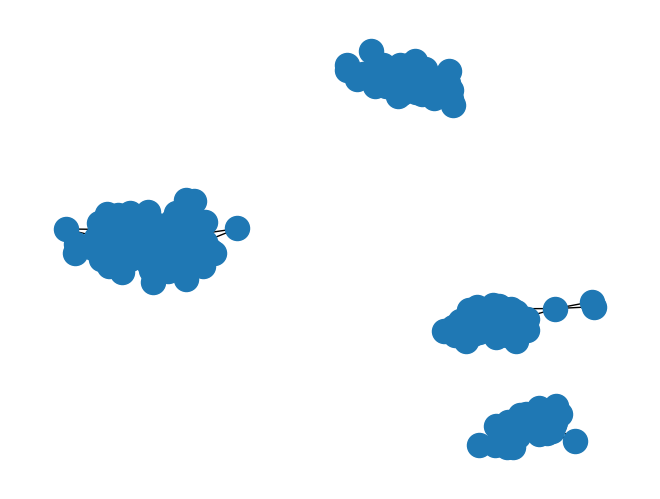

In [629]:
with open('example1.dat') as f:
    data = f.readlines()
    edges = [tuple([int(split) for split in line.split(',')[:2]]) for line in data]

maxVal = 0
for edge in edges:
    maxVal = max(max(maxVal, edge[0]), max(maxVal, edge[1]))

maxVal
graph = nx.Graph()
graph.add_nodes_from(range(1, maxVal))
graph.add_edges_from(edges)
nx.draw(graph, pos=nx.spring_layout(graph, seed=1))

In [630]:
affinity = np.zeros([maxVal, maxVal])

for edge in edges:
    affinity[edge[0]-1][edge[1]-1] = 1

affinity

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [631]:
diagonal = np.zeros([maxVal, maxVal])

for i in range(0, maxVal):
    diagonal[i][i] = np.sum(affinity[i])
    
diagonal

array([[7., 0., 0., ..., 0., 0., 0.],
       [0., 8., 0., ..., 0., 0., 0.],
       [0., 0., 9., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 2., 0., 0.],
       [0., 0., 0., ..., 0., 5., 0.],
       [0., 0., 0., ..., 0., 0., 2.]])

In [632]:
d_inv = np.linalg.inv(np.sqrt(diagonal))
laplacian = np.dot(np.dot(d_inv, affinity), d_inv)
laplacian

array([[0.        , 0.13363062, 0.12598816, ..., 0.        , 0.        ,
        0.        ],
       [0.13363062, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.12598816, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

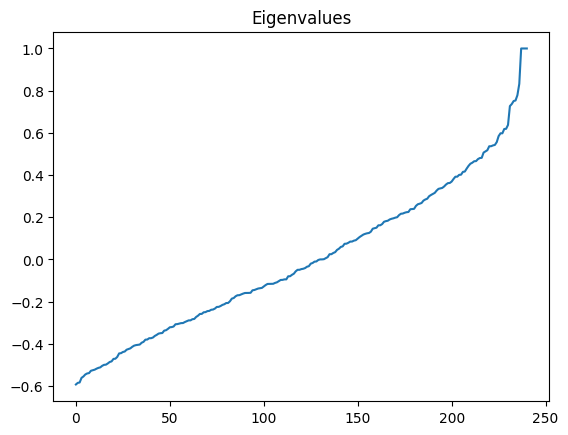

In [633]:
# Generate X (k eigenvectors)
eig_values, eig_vectors = sp.linalg.eigh(laplacian)

plt.title("Eigenvalues")
plt.plot(eig_values)
plt.show()

In [634]:
k = maxVal - np.argmax(np.ediff1d(eig_values)) - 1
x = eig_vectors[:, maxVal - k:]
k

4

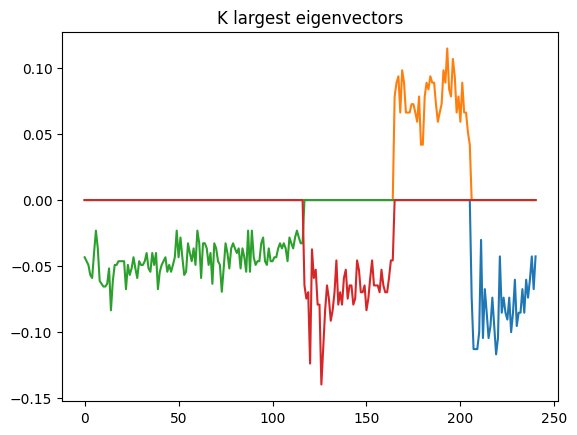

In [635]:
# Normalize X
y = x / np.linalg.norm(x)

# eig_values_norm = eig_values / np.linalg.norm(eig_values)
plt.title("K largest eigenvectors")
plt.plot(y)
plt.show()

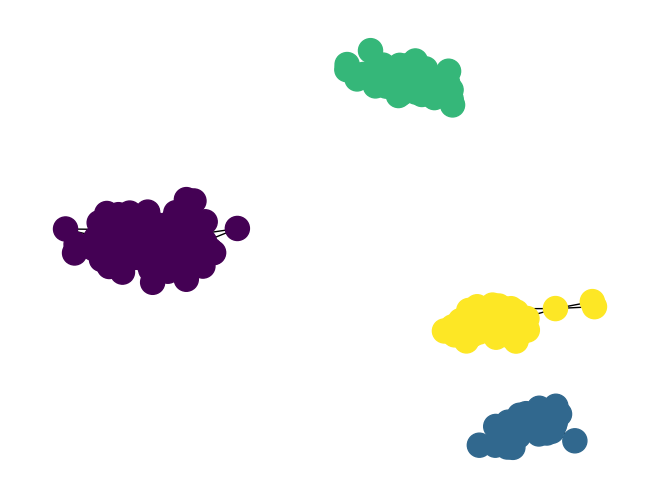

In [636]:
result = KMeans(n_clusters=k).fit_predict(y)

nx.draw(graph, pos=nx.spring_layout(graph, seed=1), node_color=result)